
### Predictive Analysis to estimate the sale price and the cost-effectiveness of doing renovations for Real-Estate company
### Regression and Classification with the Ames Housing Data

Author : Indraja Bandla

---
# scenario:

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# Check out the shape
house.shape

(1460, 81)

In [4]:
# get rid of non-residential houses
print house.MSZoning.value_counts(dropna=False)
house = house[house.MSZoning.isin(['RL','RM','RP','RH'])]
print house.shape

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
(1385, 81)


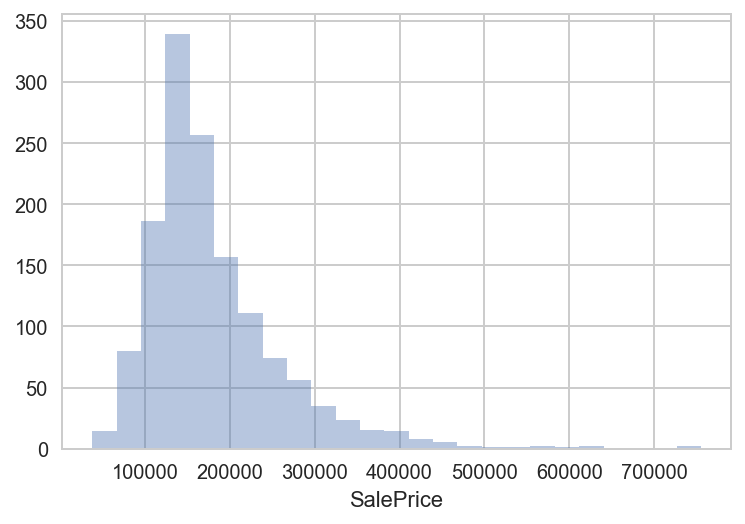

In [5]:
# look at the distribution of sale price
# skewed right
sns.distplot(house.SalePrice, kde=False, bins=25)

In [6]:
# no absurd outliers
house.SalePrice.describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

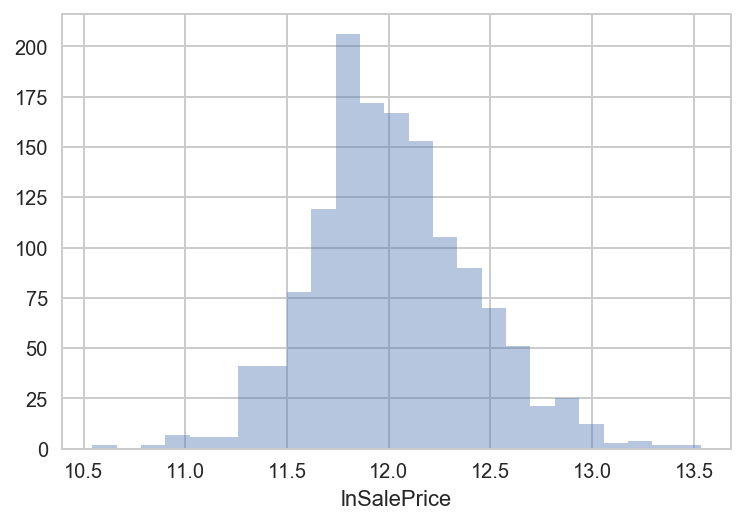

In [7]:
# natural log of house is more normally distributed, I will use this
house['lnSalePrice'] = np.log(house.SalePrice+1)
sns.distplot(house.lnSalePrice, kde=False, bins=25)

In [8]:
# calculate the age of the house when sold
house['YrAgeWhenSold'] = (house.YrSold + (house.MoSold-1)/12.) - house.YearBuilt

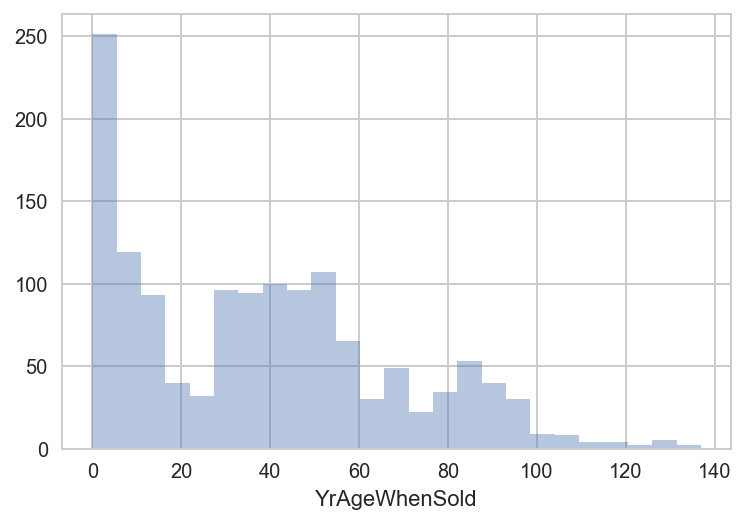

In [9]:
sns.distplot(house.YrAgeWhenSold, kde=False, bins=25)

In [10]:
# decently even distribution of years
# 2010 will be our hold-out set.
print house.YrSold.value_counts()

2009    321
2007    313
2006    299
2008    288
2010    164
Name: YrSold, dtype: int64


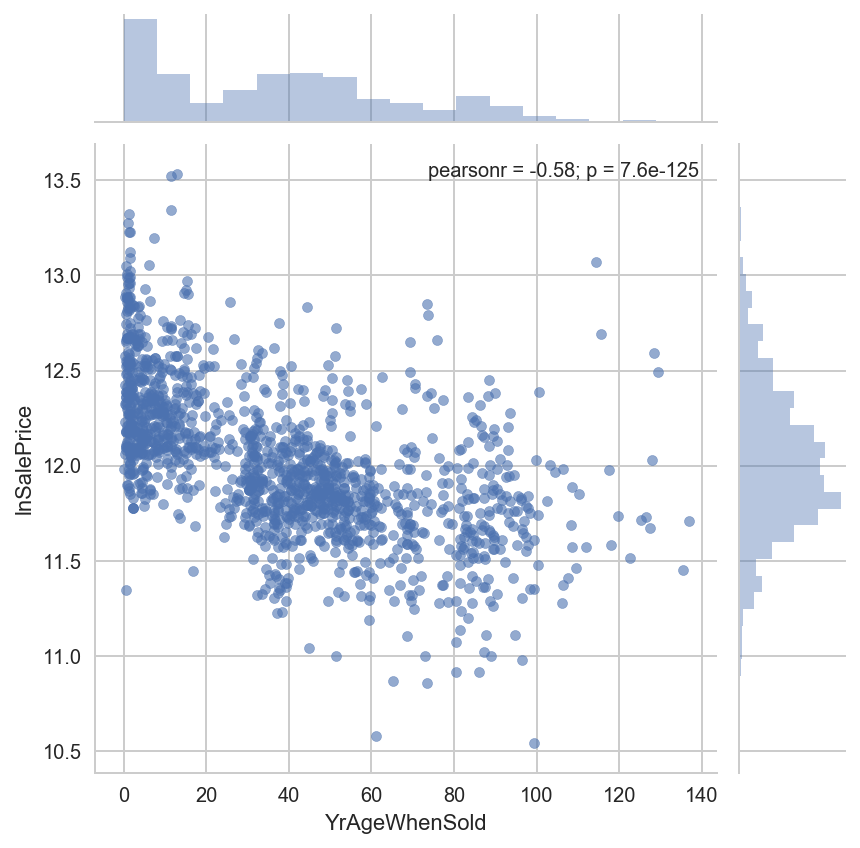

In [11]:
# plot the age of the house vs. the log sale price
# defnitely some strong signal in there
sns.jointplot(house.YrAgeWhenSold, house.lnSalePrice, joint_kws=dict(s=25, alpha=0.6))

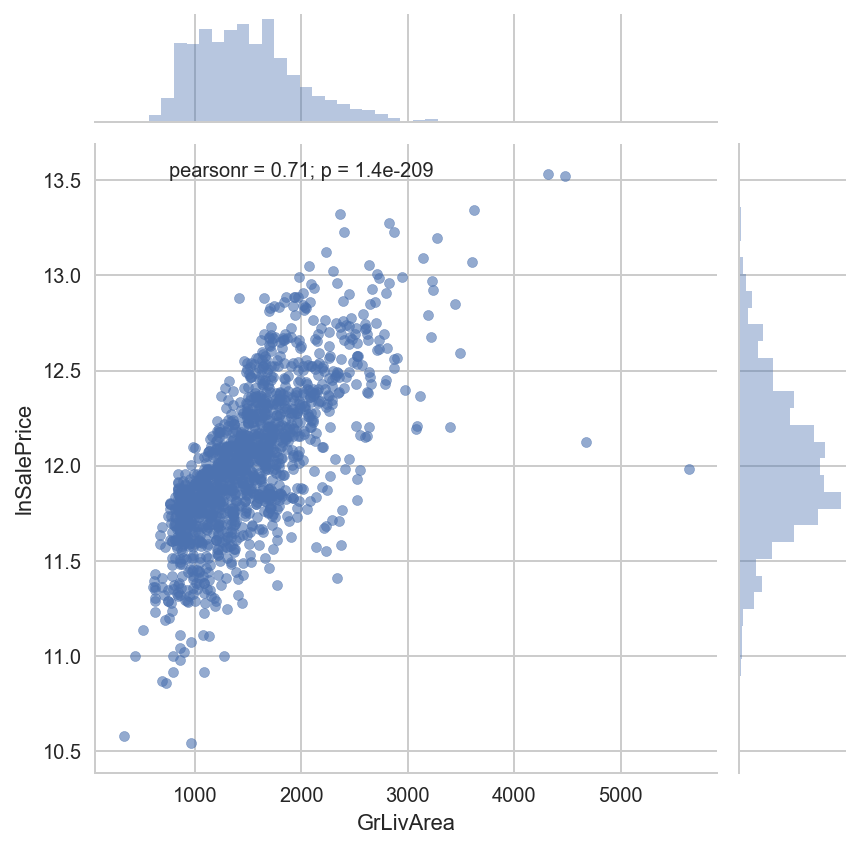

In [12]:
# the liveable area vs. the log sale price - obviously a relationship here.
sns.jointplot(house.GrLivArea, house.lnSalePrice, joint_kws=dict(s=25, alpha=0.6))

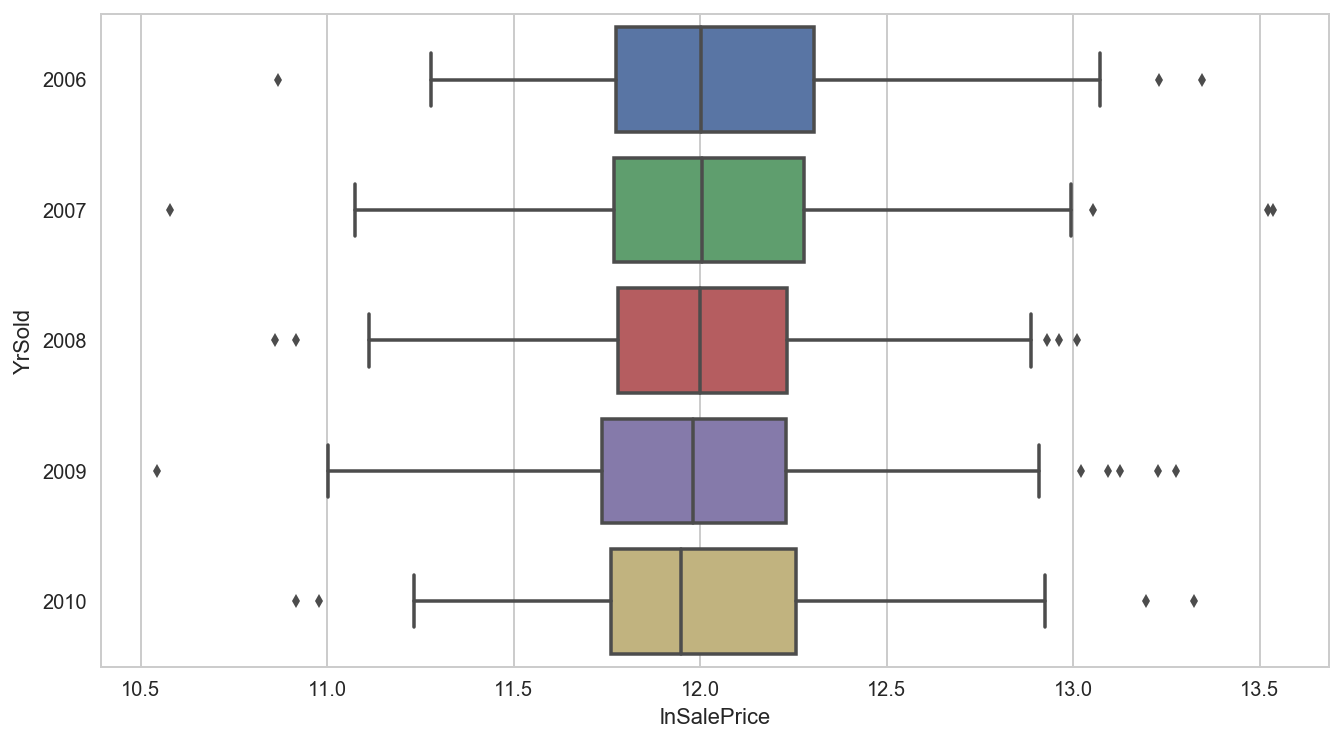

In [13]:
# look at the log sale price by year.
# if there is an effect it is not immediately apparent here.
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lnSalePrice', y='YrSold', data=house, orient='h', ax=ax)
plt.show()

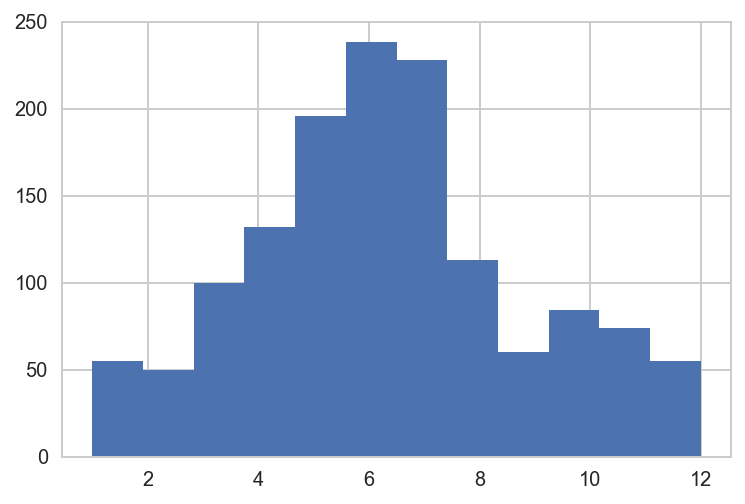

In [14]:
# more houses sold in the summer
house.MoSold.hist(bins=12)

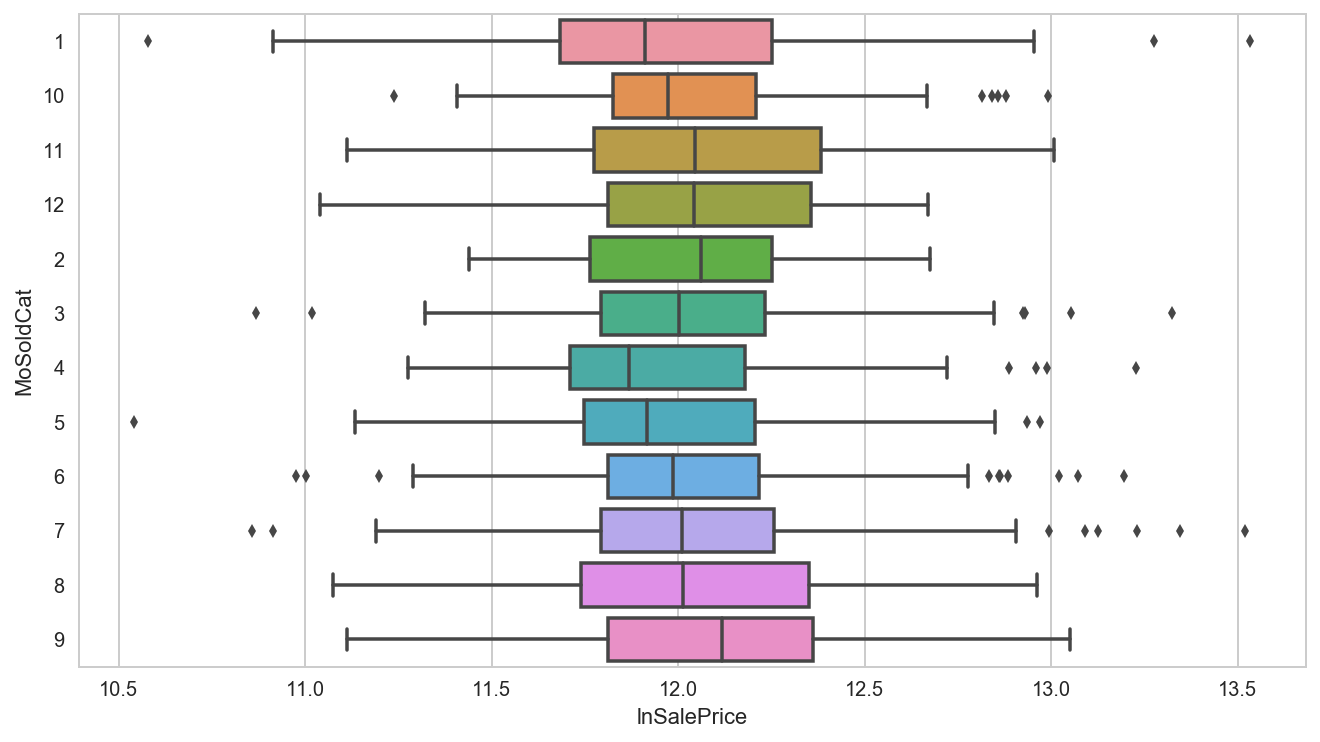

In [15]:
# look at the log sale price by month.
# may be some effects there. worth testing
house['MoSoldCat'] = house.MoSold.map(lambda x: str(x))
fig, ax = plt.subplots(figsize=(11,6))
sns.boxplot(x='lnSalePrice', y='MoSoldCat', data=house, orient='h', ax=ax)
plt.show()

In [16]:
# Find out which variables have null values.
nulls = house.isnull().sum()[house.isnull().sum() > 0]
nulls

LotFrontage      251
Alley           1320
MasVnrType         5
MasVnrArea         5
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      641
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1378
Fence           1108
MiscFeature     1333
dtype: int64

In [17]:
# Lots of variables have nulls. Some are continuous, others categorical.
# I wrote a function to fill in both. The categorical ones can be filled
# with "None" because that's what the NA means (based on the data description
# file). A few of the continuous ones can be filled with 0 as that is their 
# meaning.

# I am dropping Electrical, PoolQC, and Id. The first two have no variance - 
# useless variables. The Id is just an identifier of the house.
def col_filler(df, col, fillval='None'):
    df.loc[df[col].isnull(), col] = fillval
    return df

none_fill_cols = ['GarageType','GarageFinish','GarageQual','GarageCond','Fence',
                  'FireplaceQu','BsmtFinType2','BsmtFinType1','BsmtExposure',
                  'BsmtCond','BsmtQual','MasVnrType','MiscFeature']

zero_fill_cols = ['Alley','LotFrontage','MasVnrArea']

drop_rows = ['Electrical']
drop_cols = ['PoolQC','Id']


In [18]:
for col in none_fill_cols:
    house = col_filler(house, col, fillval='None')
    
for col in zero_fill_cols:
    house = col_filler(house, col, fillval=0.)
    
for col in drop_rows:
    house = house[~house[col].isnull()]
    
for col in drop_cols:
    house.drop(col, axis=1, inplace=True)

In [19]:
# Find out which variables remain that have null values.
nulls = house.isnull().sum()[house.isnull().sum() > 0]
nulls

GarageYrBlt    79
dtype: int64

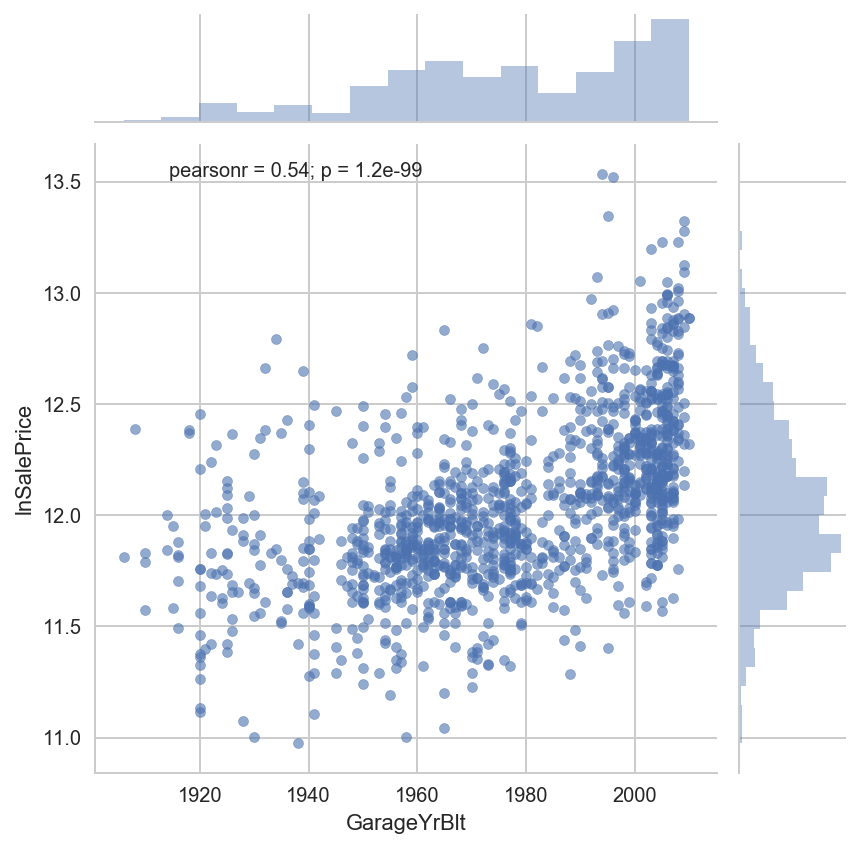

In [20]:
sns.jointplot(house.GarageYrBlt, house.lnSalePrice, joint_kws=dict(s=25, alpha=0.6))

In [21]:
# I'm going to drop garage year built despite its association with price
# due to the missing values. 
house.drop('GarageYrBlt', axis=1, inplace=True)

In [22]:
# MSSubClass: Identifies the type of dwelling involved in the sale.	
#         20	1-STORY 1946 & NEWER ALL STYLES
#         30	1-STORY 1945 & OLDER
#         40	1-STORY W/FINISHED ATTIC ALL AGES
#         45	1-1/2 STORY - UNFINISHED ALL AGES
#         50	1-1/2 STORY FINISHED ALL AGES
#         60	2-STORY 1946 & NEWER
#         70	2-STORY 1945 & OLDER
#         75	2-1/2 STORY ALL AGES
#         80	SPLIT OR MULTI-LEVEL
#         85	SPLIT FOYER
#         90	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES

# This is redundant with other variables: BldgType, HouseStyle
# I am dropping it
house.drop('MSSubClass', axis=1, inplace=True)

In [23]:
# find the proportion of the majority class
# I'm going to use this to get rid of features that don't have any variance.
# If a feature is the same value for more than 95% of observations,
# drop it.
def proportion_majority(df, col):
    max_count = df[col].value_counts().max()
    return float(max_count)/df.shape[0]

In [24]:
props = [[col,proportion_majority(house, col)] for col in house.columns]
props = pd.DataFrame(props, columns=['feature','majority'])

In [25]:
# columns where the proportion of the majority class is greater than 95%
props[props.majority > 0.95]

,feature,majority
3,Street,0.997110
4,Alley,0.953035
7,Utilities,0.999277
12,Condition2,0.989884
20,RoofMatl,0.981214
37,Heating,0.977601
43,LowQualFinSF,0.984104
50,KitchenAbvGr,0.951590
66,3SsnPorch,0.982659
68,PoolArea,0.994942


In [26]:
# remove the features with minimal variance.
prop_remove_cols = props[props.majority > 0.95].feature.values
h = house.drop(prop_remove_cols, axis=1)

In [27]:
# dropping for the sake of simplicity.
# In reality they should be included. You can do a ton of feature eng
# and eda in this project, but I'm keeeping this demo code simple.

# combine the basement sqft measures
h['BsmtFinSF'] = h.BsmtFinSF1 + h.BsmtFinSF2
h.drop(['Exterior2nd','BsmtFinType2','TotalBsmtSF','BsmtFinSF1',
        'BsmtFinSF2'], axis=1, inplace=True)


In [28]:
# these need to be renamed for patsy
h.rename(columns={'2ndFlrSF':'SecondFlrSF', '1stFlrSF':'FirstFlrSF'}, inplace=True)

In [30]:
# things about property that can be renovated or are in general related to "quality"
# or "condition" in some way. 
changeable = ['OverallCond','RoofStyle','Exterior1st','ExterCond',
              'BsmtCond','HeatingQC','CentralAir','Electrical',
              'GarageFinish','GarageCond','PavedDrive','Functional',
              'OverallQual','ExterQual','BsmtQual','GarageQual','KitchenQual',
              'FireplaceQual','YearRemodAdd']

In [31]:
# make a formula for patsy predicting log sale price from the fixed features. 
# MANY of these are categorical, so there will be a substantial number of columns.
# I have specifically encoded the years and months as categorical variables.
static_f = '''
lnSalePrice ~ MSZoning + LotFrontage + LotArea + LotShape + LandContour + LotConfig + 
LandSlope + Neighborhood + Condition1 + BldgType + HouseStyle + 
YearBuilt + MasVnrType + MasVnrArea + Foundation + 
BsmtExposure + BsmtFinType1 + BsmtUnfSF + FirstFlrSF + SecondFlrSF + 
GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + 
TotRmsAbvGrd + Fireplaces + GarageType + SaleCondition + SaleType +
GarageCars + GarageArea + WoodDeckSF + OpenPorchSF + 
EnclosedPorch + ScreenPorch + Fence + C(YrSold) + C(MoSold) + YrAgeWhenSold + BsmtFinSF -1
'''

In [32]:
import patsy

In [33]:
# get the recent year indices for testing
inds_recent = h.YrSold == 2010

In [34]:
# Make the X, y from formula
y, X = patsy.dmatrices(static_f, data=h, return_type='dataframe')
y = y.values.ravel()
print y.shape, X.shape

(1384,) (1384, 137)


In [35]:
# Standardize X before splitting
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [36]:
# make training and testing set (test is 2010)
Xtr, Xte = Xs[~inds_recent], Xs[inds_recent]
ytr, yte = y[~inds_recent], y[inds_recent]

In [37]:
Xtr = pd.DataFrame(Xtr, columns=X.columns)
Xte = pd.DataFrame(Xte, columns=X.columns)

In [38]:
print Xtr.shape, Xte.shape

(1220, 137) (164, 137)


In [39]:
# We have 137 features - I could use gridsearch to do some massive search
# across lasso, ridge, elasticnet, but I'm going for a simpler route and 
# just choosing to use lasso because I feel like with this row-to-col
# dimensionality (and knowledge of predictors) I want to do some feature
# selection during the modeling. 
# Basically - I want a subset of the features selected - I will use 
# cross-validation to find the best regularization strength. We'll see
# how many features are selected as useful.
from sklearn.linear_model import LassoCV

In [40]:
lasso_cv = LassoCV(n_alphas=300, cv=10, verbose=1)
lasso_cv.fit(Xtr, ytr)

..................................................................................................................................................................................................................................//anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=1)

In [42]:
# I'm going to make a plot of the mean CV MSE, and some 
# bands for the standard deviation of MSE. I'll plot them
# along the alphas. 
# I will also plot a line where the best alpha was found.
mean_mse = np.array([np.mean(x) for x in lasso_cv.mse_path_])
std_mse = np.array([np.std(x) for x in lasso_cv.mse_path_])
alphas = lasso_cv.alphas_

best alpha =  0.00426973981019


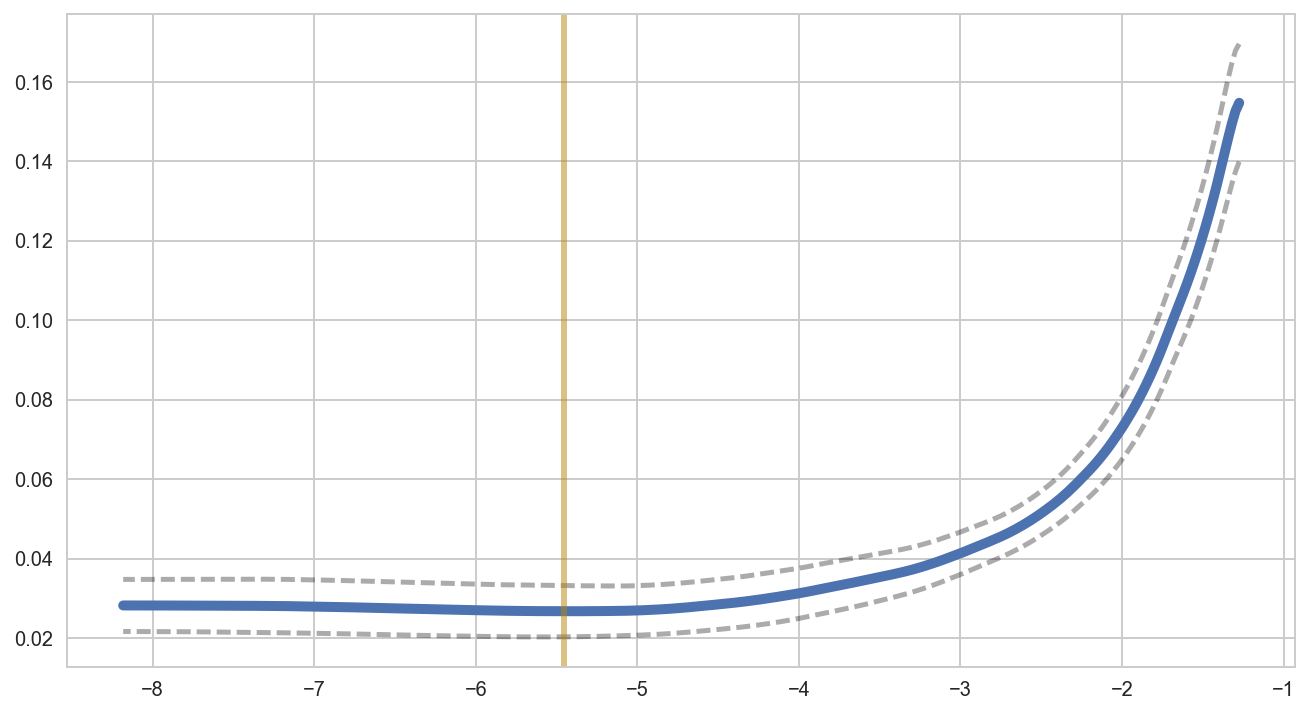

In [43]:
std_plus = mean_mse+std_mse/2.
std_minus = mean_mse-std_mse/2.

fig, ax = plt.subplots(figsize=(11,6))

ln_alphas = np.log(alphas)

ax.plot(ln_alphas, mean_mse, lw=5)

ax.plot(ln_alphas, std_plus, lw=2.5, ls='dashed', c='black', alpha=0.33)
ax.plot(ln_alphas, std_minus, lw=2.5, ls='dashed', c='black', alpha=0.33)

min_mse = np.min(mean_mse)
best_alpha = np.where(mean_mse == min_mse)[0][-1]

ax.axvline(x=ln_alphas[best_alpha], lw=3, c='darkgoldenrod', alpha=0.5)
print 'best alpha = ', np.exp(ln_alphas[best_alpha])
plt.show()

In [44]:
# Put the features and coefs into a dataframe
# sort by magnitude
lasso_feat = pd.DataFrame(dict(feature=X.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
lasso_feat[lasso_feat.coef != 0.]

,abscoef,coef,feature
121,0.129324,0.129324,GrLivArea
129,0.058709,0.058709,GarageCars
30,0.045825,0.045825,Neighborhood[T.NridgHt]
135,0.033360,-0.033360,YrAgeWhenSold
116,0.032011,0.032011,YearBuilt
20,0.029962,0.029962,Neighborhood[T.Crawfor]
128,0.028497,0.028497,Fireplaces
36,0.026888,0.026888,Neighborhood[T.StoneBr]
73,0.020255,-0.020255,BsmtFinType1[T.None]
21,0.019840,-0.019840,Neighborhood[T.Edwards]


In [45]:
# Notes: 
# There are 72 selected features! That's quite a few. The top variables make 
# sense as far as what is important to estimate the price:
# livable area, cars in garage, neighborhood, age when sold, fireplaces, etc.
# These coefficients are a bit hard to interpret:
# 1. They are in terms of standard deviations of the predictor.
# 2. The target is in log terms (orders of magnitude)
# So basically a coefficient is saying "for a 1 standard deviation increase in
# this predictor, there will be x increase in orders of magnitude of the sale price"

In [46]:
lasso_cv.alpha_

0.0042697398101869078

In [47]:
from sklearn.linear_model import Lasso
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(Xtr, ytr)

Lasso(alpha=0.0042697398101869078, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [49]:
# Testing on 2010 we see that we have an R2 of 89.
# 89% of variance in price explained is quite good.
best_lasso.score(Xte, yte)

0.89060900902157525

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any effects of changeable property characteristics on variance in price unexplained by the fixed characteristics.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [50]:
# get out the residuals for training and testing, in terms of dollars.
tr_resids = np.exp(ytr) - np.exp(best_lasso.predict(Xtr))
te_resids = np.exp(yte) - np.exp(best_lasso.predict(Xte))

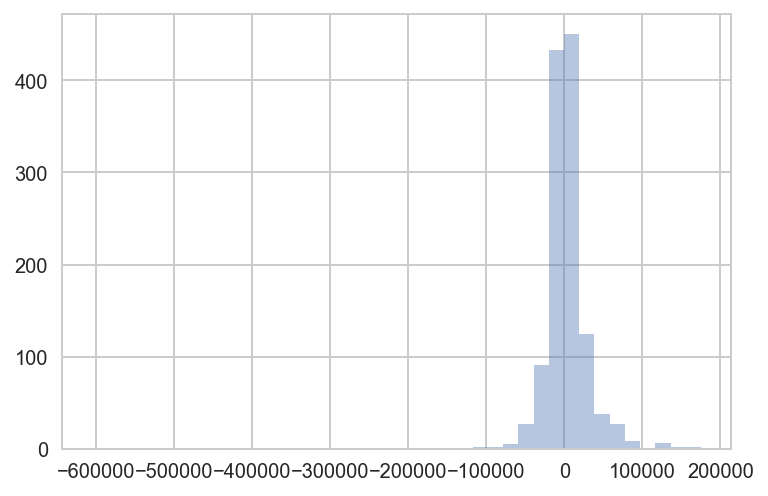

In [51]:
# looks like there is a bad outlier in there...
sns.distplot(tr_resids, kde=False, bins=40)

In [60]:
# there is definitely a wild prediction in there...
print tr_resids.min()
print stats.scoreatpercentile(tr_resids, 0.5)

-604765.859219
-67448.8792951


In [61]:
# truncate the minimum at -70000:
tr_resids[tr_resids < -70000] = -70000

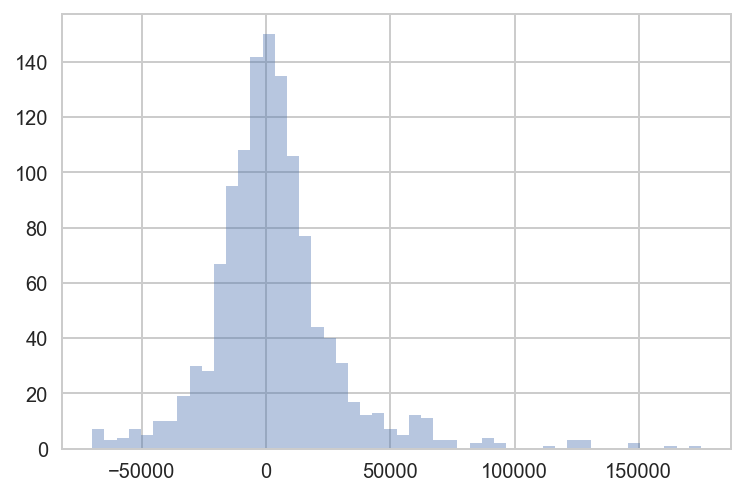

In [63]:
sns.distplot(tr_resids, kde=False)

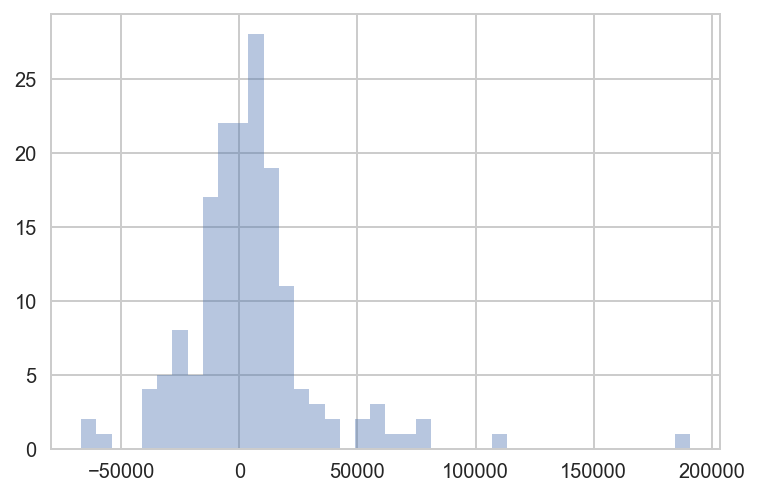

In [64]:
sns.distplot(te_resids, kde=False, bins=40)

In [65]:
# things that could be done via renovation:
renovations = ['RoofStyle','Exterior1st','ExterCond',
              'BsmtCond','HeatingQC','CentralAir','Electrical',
              'GarageFinish','GarageCond','PavedDrive',
              'ExterQual','BsmtQual','GarageQual','KitchenQual',
              'FireplaceQu']
# Note that I have omitted the "overall" quality and condition ones. 
# Those aren't really specific renovations - I want to pinpoint the specific
# things that have an effect on expected price, and by how much. Overall
# is just too vague.

In [66]:
renovation_f = '~ '+' + '.join(renovations)+' -1'

In [68]:
# make the renovation predictor matrix
Xren = patsy.dmatrix(renovation_f, data=h, return_type='dataframe')
print Xren.shape

(1384, 67)


In [69]:
# standardize it
ss = StandardScaler()
Xrens = ss.fit_transform(Xren)

In [70]:
# split by year again
Xren_tr, Xren_te = Xrens[~inds_recent], Xrens[inds_recent]

In [71]:
# Going to search over the ridge this time. Instead of going
# for feature elimination I am looking to mitigate multicollinearity
# and keep all the renovations in.
from sklearn.linear_model import RidgeCV

In [72]:
ren_cv = RidgeCV(alphas=np.logspace(-5,4,300), cv=10)

In [73]:
ren_cv.fit(Xren_tr, tr_resids)

RidgeCV(alphas=array([  1.00000e-05,   1.07177e-05, ...,   9.33039e+03,   1.00000e+04]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [74]:
ren_cv.alpha_

78.15856707684091

In [75]:
ren_cv.score(Xren_tr, tr_resids)

0.22492956034042588

In [76]:
ren_cv.score(Xren_te, te_resids)

0.2240074527021364

In [77]:
# We are explaining 22% of the variance in the remaining variance in price 
# NOT explained by the fixed characteristics of the house.
# Notably, we are preforming basically the same on training and testing. This
# is great! It means our model generalizes very well out of sample. Despite
# the R2 being low, this alone makes me trust the variance we are explaining.

In [81]:
renovation_coefs = pd.DataFrame(dict(coef=ren_cv.coef_,
                                     abscoef=np.abs(ren_cv.coef_),
                                     feature=Xren.columns))
renovation_coefs.sort_values('abscoef', ascending=False, inplace=True)
renovation_coefs.head(25)
# Below I am sorting by coef magnitude for the 2nd model.
# What does this say? Well we are predicting the dollar amount now,
# but note it is in terms of ERRORS of the first model.
# so for example, if the first model overestimated the price for a 
# house, then the error in price (residual) would be negative. 
# We are predicting those residuals. 
# Luckily, positive and negative still means the same thing. Our
# 3429 coef on Exterior Brick face means that this feature is "worth"
# 3429 dollars (it is estimated to be 3429 dollars greater).

# Many of these features would do well to be converted onto a numeric
# scale to make them more interpretable. If i had more time I would
# (such as the good, average, bad quality ones).

# We can use these features to evaluate how much in dollars a renovation
# is worth. For example if we wanted to upgrade a kitchen from "fair" (TA)
# to "good" (Gd) then we would evaluate the differences in their coefficients.
# The good kitchen is less negative than the average. The difference between
# them is an estimate of how much value we would gain making that change.

,abscoef,coef,feature
61,8214.671200,-8214.671200,KitchenQual[T.TA]
60,5927.627527,-5927.627527,KitchenQual[T.Gd]
49,5321.758870,-5321.758870,ExterQual[T.TA]
51,4335.661180,-4335.661180,BsmtQual[T.Gd]
58,3914.356472,-3914.356472,GarageQual[T.TA]
8,3429.323012,3429.323012,Exterior1st[T.BrkFace]
53,3244.614579,-3244.614579,BsmtQual[T.TA]
48,3120.899006,-3120.899006,ExterQual[T.Gd]
54,2966.739989,-2966.739989,GarageQual[T.Fa]
59,2492.598183,-2492.598183,KitchenQual[T.Fa]


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [82]:
# check out the value counts
h.SaleCondition.value_counts()

Normal     1154
Partial     103
Abnorml      92
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [83]:
# code up the target binary class variable
abnorm = h.SaleCondition.map(lambda x: 1 if x == 'Abnorml' else 0)
abnorm.value_counts(dropna=False)

0    1292
1      92
Name: SaleCondition, dtype: int64

In [84]:
abnorm = abnorm.values

In [85]:
# build a patsy formula for the design matrix. I'm going to throw everything
# at it in a bit - you'll see soon enough.
abnorm_f = '''
~ LotFrontage + LotArea + LotShape + LandContour + LotConfig + LandSlope + 
Neighborhood + Condition1 + BldgType + HouseStyle + OverallQual + OverallCond + 
YearBuilt + YearRemodAdd + RoofStyle + Exterior1st + MasVnrType + MasVnrArea + 
ExterQual + ExterCond + Foundation + BsmtQual + BsmtCond + BsmtExposure + 
BsmtFinType1 + BsmtUnfSF + HeatingQC + CentralAir + Electrical + FirstFlrSF + 
SecondFlrSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + 
BedroomAbvGr + KitchenQual + TotRmsAbvGrd + Functional + Fireplaces + FireplaceQu + 
GarageType + GarageFinish + GarageCars + GarageArea + GarageQual + GarageCond + 
PavedDrive + WoodDeckSF + OpenPorchSF + EnclosedPorch + ScreenPorch + Fence + C(MoSold) + 
C(YrSold) + lnSalePrice + YrAgeWhenSold  + BsmtFinSF -1
'''

In [86]:
Xabn = patsy.dmatrix(abnorm_f, data=h, return_type='dataframe')

In [87]:
# gotta standardize!
ss = StandardScaler()
Xabns = ss.fit_transform(Xabn)
Xabns = pd.DataFrame(Xabns, columns=Xabn.columns)

In [88]:
Xabns.shape

(1384, 198)

In [92]:
# import the gradient descent classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [93]:
# Below is a function to bootstrap ridge regression coefficients
# while downsampling. Here is my procedure:
# 1. Downsample the data to the abnormal observations and an
# equal number of randomly sampled with replacement samples from
# the other sale types.
# 2. For a set number of bootstrap iterations, fit an optimized
# ridge regression on the downsampled & bootstrapped data.
# 3. Save the coefficients (and scores) on each iteration
#
# I will use the boostrapped coefficients to find the confidence
# intervals around the coefficients for each of the predictors.
# The downsampling allows the classifier to perform properly.
#
# Any coefficients with 0. in their 95% confidence interval range
# will be removed - only those consistently above or below
# 0 will be kept as "real" predictors of abnormal sales.

def downsample_boot_coefs(X, y, iters=100):
    coefs = []
    cv_scores = []
    alphas = []
    
    pos = np.where(y == 1)[0]
    neg = np.where(y == 0)[0]
    
    lr_params = {
        'penalty':['l2'],
        'loss':['log'],
        'alpha':np.logspace(-4,2,30),
        'n_iter':[5]
    }
    
    for i in range(iters):
            
        neg_inds = np.random.choice(neg, size=len(pos), replace=True)
        inds = np.concatenate([pos, neg_inds])
        
        X_, y_ = X.iloc[inds, :], y[inds]
        
        lr_sgd_gs = GridSearchCV(SGDClassifier(), lr_params, cv=5)
        lr_sgd_gs.fit(X_, y_)
        
        cv_scores.append(lr_sgd_gs.best_score_)
        coefs.append(lr_sgd_gs.best_estimator_.coef_)
        alphas.append(lr_sgd_gs.best_params_['alpha'])
        
        if (i % 10) == 0:
            print i, np.mean(cv_scores), np.std(cv_scores), np.mean(alphas)
        
    return coefs, cv_scores


In [94]:
coefs, scores = downsample_boot_coefs(Xabns, abnorm)

0 0.54347826087 0.0 1.37382379588
10 0.591897233202 0.0328101931144 0.522639846508
20 0.596273291925 0.0288627799619 0.944504790188
30 0.595546984572 0.0290145940938 0.744542007641
40 0.598621420997 0.0333202884083 0.871480149159
50 0.600809889173 0.0351277916345 0.852237431641
60 0.600677120456 0.0346756216857 0.837733758673
70 0.601653398653 0.0329184406853 0.834168540094
80 0.602120236178 0.0321663961505 0.873524911204
90 0.601110845676 0.0312970715808 0.867733980373


In [95]:
# The scores are on average arount 60% accuracy during the bootstrapping.
# The baseline rate is in this case enforced to be 50%.

In [96]:
# Put the bootstrapped coefficients into a dataframe.
coef_mat = np.array([x[0] for x in coefs])
coef_mat = pd.DataFrame(coef_mat, columns=Xabns.columns)

In [97]:
coef_mat.head()

,LotShape[IR1],LotShape[IR2],LotShape[IR3],LotShape[Reg],LandContour[T.HLS],LandContour[T.Low],LandContour[T.Lvl],LotConfig[T.CulDSac],LotConfig[T.FR2],LotConfig[T.FR3],...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,lnSalePrice,YrAgeWhenSold,BsmtFinSF
0,0.000926,-0.000020,-0.002241,-0.000508,-0.011885,0.024334,-0.019186,-0.008915,-0.027734,-0.001224,...,-0.005904,-0.018668,-0.014547,-0.008187,-0.005324,0.039981,0.030211,-0.044960,0.011550,0.007780
1,-0.057509,-0.013407,0.023596,0.056696,-0.035961,0.033358,0.074638,0.097984,-0.152962,0.012891,...,-0.071536,-0.017659,-0.023317,0.066053,-0.119649,0.105820,0.050035,-0.113474,0.007223,0.121296
2,0.001447,0.024169,-0.012426,-0.007396,-0.127025,0.124206,-0.057933,0.146041,-0.042131,-0.006789,...,-0.124367,-0.028829,-0.102007,0.049553,0.006185,0.069534,0.069683,-0.199577,0.044728,0.107998
3,0.009135,0.036718,-0.000271,-0.021280,-0.148566,0.098516,-0.121666,-0.068795,-0.019993,-0.062375,...,-0.010407,0.039895,0.073286,-0.083417,-0.047676,0.059819,0.086811,-0.119366,0.019440,0.029013
4,-1.057202,1.179164,-1.853444,0.961255,-1.296741,1.671293,0.104475,0.091751,-1.082397,-0.088634,...,-1.335407,-0.781857,-0.113064,-0.101786,2.410869,-0.584203,3.445448,-3.940698,-0.165593,1.547264


In [98]:
# calculate the lower 2.5th percentile coef, upper 97.5th percentile coef,
# and the median coefficient.
# The features whose 95% confidence intervals do not include 0 are kept
lower = coef_mat.apply(lambda x: stats.scoreatpercentile(x, 2.5), axis=0)
median = coef_mat.apply(lambda x: np.median(x), axis=0)
upper = coef_mat.apply(lambda x: stats.scoreatpercentile(x, 97.5), axis=0)

In [99]:
np.sum(lower*upper > 0)

13

In [100]:
valid_features = [c for i,c in enumerate(coef_mat.columns) if i in np.where((lower*upper > 0).values)[0]]
valid_features

['Neighborhood[T.NAmes]',
 'Neighborhood[T.NoRidge]',
 'Neighborhood[T.NridgHt]',
 'HouseStyle[T.SLvl]',
 'Exterior1st[T.BrkComm]',
 'Exterior1st[T.Stone]',
 'Electrical[T.Mix]',
 'Functional[T.Sev]',
 'FireplaceQu[T.Gd]',
 'Fence[T.None]',
 'C(MoSold)[T.6]',
 'YearRemodAdd',
 'lnSalePrice']

In [101]:
median[valid_features]

Neighborhood[T.NAmes]      0.056380
Neighborhood[T.NoRidge]    0.078572
Neighborhood[T.NridgHt]   -0.063116
HouseStyle[T.SLvl]         0.069047
Exterior1st[T.BrkComm]     0.057137
Exterior1st[T.Stone]       0.088576
Electrical[T.Mix]          0.039271
Functional[T.Sev]          0.051192
FireplaceQu[T.Gd]         -0.071528
Fence[T.None]             -0.063757
C(MoSold)[T.6]            -0.099273
YearRemodAdd              -0.079287
lnSalePrice               -0.081190
dtype: float64

In [102]:
# These are the valid features indicating forclosure vs. not.
# features predicting forclosure:
# 1. North Ames neighborhood
# 2. North Ridge neighborhood
# 3. Single level house
# 4. Brick and stone exterior
# 5. Electrical "mix"
# 6. "Severe" functionality of house (bad)

# features predicting against forclosure:
# 1. North ridge heights neighborhood
# 2. Good quality fireplace
# 3. No fence
# 4. Sold in month 6. Interesting.
# 5. A later year remodeled (more recent)
# 6. A lower sale price. 